In [1]:
import pandas as pd
import numpy as np
import bluebelt as blue
import matplotlib.pyplot as plt

In [508]:
nrows = 28 + 7 * 14
ncols = 4

np.random.seed(27)
series = pd.Series(np.random.weibull(7,nrows) * 100, index=pd.date_range(start='2019-12-2', periods=nrows), name='process A')
frame = pd.DataFrame(np.random.normal(loc=100, scale=20, size=ncols*nrows).reshape(nrows, ncols), index=pd.date_range(start='1-1-2020', periods=nrows), columns=[f'process {col}' for col in range(1, ncols+1)])

series[series.sample(5).index] = np.nan # break the series
for col in frame.columns:
    frame.at[frame.sample(5).index, col] = np.nan # break the frame

In [509]:
s = series.blue.index.groupby(level=['year', 'week', 'day']).sum()

In [304]:
# dit ophalen
# ticks = axes.get_xticks()

# t = [int(tick) for tick in ticks if tick in range(len(s))]

# als len ticks > level length dan next level
# anders deze level pakken en ticklabels bepalen
# daarna weer een level terug en deze toevoegen op locatie mediaan van bovenliggende

def get_tick_level(ticks, levels):
    for level in range(levels):
        if len(ticks) <= len(s.index.levels[level]):
            return level
        
# get_tick_level(t, s.index.nlevels)

In [305]:
#def get_xticks(level, factor):
    
# nog toevoegen


# - year level
# - bij overgang naar nieuw jaar een knip
# - vaste lengte?
#
# - de codes staan niet altijd in volgorde
# => eerst een recode met wel de juiste volgorde?
# => overgang tussen jaren @#$@#$%**!!!!


level = 1
factor = 3

# get label location and values
# get current codes
codes = s.index.codes[level]

# recode codes
recode = lambda x: np.floor(x/factor)
codes = recode(codes).astype(int)

values = np.array([s.index.levels[level][x] for x in s.index.codes[level]])

# make bins
bins = np.bincount(codes)

# get bin medians
median_func = lambda x: (x-1)/2
bin_medians = median_func(bins)

# get bin cumsum for 0 + bins[:-1]
bin_cumsum = np.insert(bins,0,0)[:-1]
bin_cumsum = np.cumsum(bin_cumsum)

# calculate new ticks
new_xticks = np.add(bin_cumsum, bin_medians)

# make new labels
if factor > 1:
    # get first and last value
    s1 = s.index.levels[level][::factor]
    s2 = s.index.levels[level][factor-1::factor]

    # check if the last tick value is in s1 or s2
    if not s.index.levels[level][-1] in np.concatenate((s1, s2), 0):
        s2 = np.append(s2, s.index.levels[level][-1])

    # build new labels
    new_xticklabels = [f'{s1[i]}-{s2[i]}' if i < len(s2) else f'{s1[i]}' for i in range(len(s1))]
    # new_xticklabels = [f'{s1[i]}-' if i < len(s2) else f'{s1[i]}' for i in range(len(s1))]
else:
    new_xticklabels = s.index.levels[level]

# calculate location of lines
locations = np.concatenate(([1,], np.diff(codes, n=1)[:-1])).nonzero()[0]
locations = np.concatenate((locations, [s.shape[0] + 1]))
locations = locations - 0.5
#return new_xticks, new_xticklabels, locations

In [306]:
np.array([s.index.levels[1][code] for code in s.index.codes[1]])

array([49, 49, 49, 49, 49, 49, 49, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51,
       51, 51, 51, 51, 52, 52, 52, 52, 52, 52, 52,  1,  1,  1,  1,  1,  1,
        1,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  4,  4,
        4,  4,  4,  4,  4])

In [491]:
#
# dit is de goede!!!
# alleen nog de jaarwisselingen
#
#



def get_xticks(index, level, factor):
    
    codes = index.codes[level]
    
    # build values
    values = np.array([index.levels[level][code] for code in codes])
    label_values = values[np.where(np.append(values[:-1] != values[1:], True))[0]]
    values = (np.ceil((values / factor) - 1) * factor) + 1
    
    
    sub_values = np.concatenate(([0,], (np.where(values[:-1] != values[1:])[0]) + 1, [len(values)]))

    # get interval medians
    median_func = lambda x: (x-1)/2
    intervals = sub_values[1:]-sub_values[:-1]
    intervals = median_func(intervals)

    # get new xticks
    xticks = intervals + sub_values[:-1]

    # make new labels
    # get only the first number of a sequence
    #firsts = index.codes[level][np.where(np.append(index.codes[level][:-1] != index.codes[level][1:], True))[0]]
    #values = np.array([index.levels[level][code] for code in firsts])
    label_values_f = (np.ceil((label_values / factor) - 1) * factor) + 1
    index_min = np.concatenate(([0,], (np.where(label_values_f[:-1] != label_values_f[1:])[0]) + 1))
    index_max = np.concatenate((np.where(label_values_f[:-1] != label_values_f[1:])[0], [len(label_values_f) - 1]))


    s1 = np.maximum(np.array([label_values[i] for i in index_min]), np.array([label_values_f[i] for i in index_min])).astype(int)
    s2 = np.array([label_values[i] for i in index_max]).astype(int)
    if factor > 1:
        # get first and last value
        # s1 = label_values[::factor]
        # s2 = label_values[factor-1::factor]

        # check if the last tick value is in s1 or s2
        if not label_values[-1] in np.concatenate((s1, s2), 0):
            s2 = np.append(s2, label_values[-1])

        # build new labels
        xticklabels = [f'{s1[i]}-{s2[i]}' if (s1[i]!=s2[i] and i < len(s2)) else f'{s1[i]}' for i in range(len(s1))]
    else:
        xticklabels = label_values

    # calculate location of lines
    line_locations = np.concatenate(([1,], np.diff(values, n=1)[:-1])).nonzero()[0]
    line_locations = (np.concatenate((line_locations, [s.shape[0]])))
    line_locations = line_locations - 0.5
    
    return xticks, xticklabels, line_locations

In [573]:
import matplotlib.transforms as transforms

def _get_multiindex_xticks(index, level, factor):
    
    codes = index.codes[level]
    
    # build values
    values = np.array([index.levels[level][code] for code in codes])
    label_values = values[np.where(np.append(values[:-1] != values[1:], True))[0]]
    values = (np.ceil((values / factor) - 1) * factor) + 1
    
    
    sub_values = np.concatenate(([0,], (np.where(values[:-1] != values[1:])[0]) + 1, [len(values)]))

    # get interval medians
    median_func = lambda x: (x-1)/2
    intervals = sub_values[1:]-sub_values[:-1]
    intervals = median_func(intervals)

    # get new xticks
    xticks = intervals + sub_values[:-1]

    # make new labels
    label_values_grouped = (np.ceil((label_values / factor) - 1) * factor) + 1
    index_min = np.concatenate(([0,], (np.where(label_values_grouped[:-1] != label_values_grouped[1:])[0]) + 1))
    index_max = np.concatenate((np.where(label_values_grouped[:-1] != label_values_grouped[1:])[0], [len(label_values_grouped) - 1]))
    s1 = np.maximum(np.array([label_values[i] for i in index_min]), np.array([label_values_grouped[i] for i in index_min])).astype(int)
    s2 = np.array([label_values[i] for i in index_max]).astype(int)
    if factor > 1:
        # check if the last tick value is in s1 or s2
        if not label_values[-1] in np.concatenate((s1, s2), 0):
            s2 = np.append(s2, label_values[-1])
        xticklabels = [f'{s1[i]}-{s2[i]}' if (s1[i]!=s2[i] and i < len(s2)) else f'{s1[i]}' for i in range(len(s1))]
    else:
        xticklabels = label_values

    # calculate location of lines
    line_locations = np.concatenate(([1,], np.diff(values, n=1)[:-1])).nonzero()[0]
    line_locations = (np.concatenate((line_locations, [s.shape[0]])))
    line_locations = line_locations - 0.5
    
    return xticks, xticklabels, line_locations

def _find_multiindex_levels(index, levels):
    names = index.names
    if isinstance(levels, str):
        levels = names.index(levels)
    elif isinstance(levels, int):
        levels = levels
    elif isinstance(levels, (list, tuple)):
        levels = sorted([_find_index_levels(index=index, levels=level) for level in levels], reverse=True)
        
    if not isinstance(levels, list):
        levels = [levels]
    return levels

def _add_line(ax, xpos, ypos, length):
    trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
    line = plt.Line2D([xpos, xpos], [ypos - length, ypos], color='black', transform=trans)
    line.set_clip_on(False)
    ax.add_line(line)
    
def set_multiindex_xticks(ax, index, levels=[0, 1], factor=1):
    trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
    # get the proper levels
    levels = _find_multiindex_levels(index=index, levels=levels)
    
    # hide the old ticks
    ax.tick_params(axis='x', length=0)
    
    for i, level in enumerate(levels):
        if i == 0:
            xticks, xticklabels, line_locations = _get_multiindex_xticks(index=index, level=level, factor=factor)
            
            # set real xticks
            ax.set_xticks(xticks)
            ax.set_xticklabels(xticklabels)
            
            # draw lines between xticks
            ypos = 0.005
            length = 0.01
            for xpos in line_locations:
                _add_line(axes, xpos, ypos, length)
                
        else:
            xticks, xticklabels, line_locations = _get_multiindex_xticks(index=index, level=level, factor=1)
            
            label_pos = -0.08
            # set extra xticks
            for tick, label in zip(xticks, xticklabels):
                ax.text(tick, label_pos, label, ha='center', transform=trans)
            
            # draw lines between xticks
            ypos = 0.005
            length = 0.08
            for xpos in line_locations:
                _add_line(axes, xpos, ypos, length)
             

In [548]:
def _find_multiindex_levels(index, levels):
    names = index.names
    if isinstance(levels, str):
        levels = names.index(levels)
    elif isinstance(levels, int):
        levels = levels
    elif isinstance(levels, (list, tuple)):
        levels = sorted([_find_index_levels(index=index, levels=level) for level in levels], reverse=True)
        
    if not isinstance(levels, list):
        levels = [levels]
    return levels
    
_find_multiindex_levels(index=s.index, levels=['week', 'year'])


[1, 0]

In [550]:
x = ['a','b','c']
y = ['d','e','f']

for z in zip(x,y):
    print(z[0])

a
b
c


In [334]:
sub_vals = np.concatenate(([0,], (np.where(vals[:-1] != vals[1:])[0]) + 1, [len(vals)]))

# get interval medians
median_func = lambda x: (x-1)/2
intervals = sub_vals[1:]-sub_vals[:-1]
intervals = median_func(intervals)

# get new xticks
xticks = intervals + sub_vals[:-1]
xticks

array([13.5, 41.5])

In [332]:
len(vals)

56

In [320]:
vals

array([49, 49, 49, 49, 49, 49, 49, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51,
       51, 51, 51, 51, 52, 52, 52, 52, 52, 52, 52,  1,  1,  1,  1,  1,  1,
        1,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  4,  4,
        4,  4,  4,  4,  4])

In [323]:
# maar dat geen nan maar de vorige code dus
np.where(vals==x, codes, np.nan)

# iets met list comprehension?

array([ 4.,  4.,  4.,  4.,  4.,  4.,  4., nan, nan, nan, nan, nan, nan,
       nan,  6.,  6.,  6.,  6.,  6.,  6.,  6., nan, nan, nan, nan, nan,
       nan, nan,  0.,  0.,  0.,  0.,  0.,  0.,  0., nan, nan, nan, nan,
       nan, nan, nan,  2.,  2.,  2.,  2.,  2.,  2.,  2., nan, nan, nan,
       nan, nan, nan, nan])

In [494]:
def _add_line(ax, xpos, ypos):
    trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
    line = plt.Line2D([xpos, xpos], [ypos - 0.01, ypos], color='black', transform=trans)
    line.set_clip_on(False)
    ax.add_line(line)

In [557]:
_get_multiindex_xticks(index=s.index, level=1, factor=1)

(array([  3.,  10.,  17.,  24.,  31.,  38.,  45.,  52.,  59.,  66.,  73.,
         80.,  87.,  94., 101., 108., 115., 122.]),
 array([49, 50, 51, 52,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,
        14]),
 array([ -0.5,   6.5,  13.5,  20.5,  27.5,  34.5,  41.5,  48.5,  55.5,
         62.5,  69.5,  76.5,  83.5,  90.5,  97.5, 104.5, 111.5, 118.5,
        125.5]))

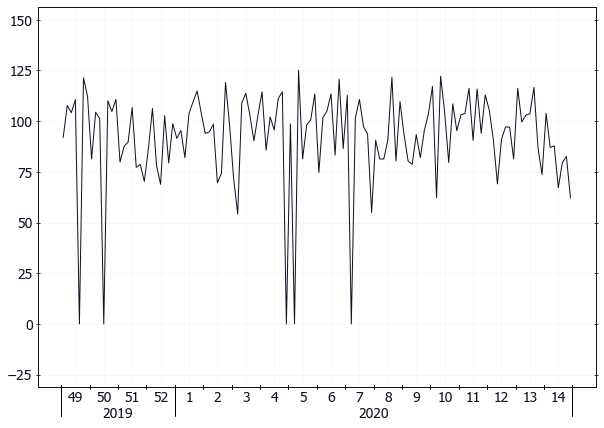

In [578]:
fig, axes = plt.subplots(nrows=1, ncols=1)
axes.plot(range(0, len(s), 1), s)
set_multiindex_xticks(ax=axes, index=s.index)        
plt.show()

In [515]:
new_xticks, new_xticklabels, locations = get_xticks(codes=s.index.codes[1], factor=1)
locations

TypeError: get_xticks() got an unexpected keyword argument 'codes'

In [15]:
np.array([s.index.levels[1][level] for level in s.index.codes[1]])

array([1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5])